In [29]:
import os
import tqdm
from langchain.chat_models import ChatOpenAI
from typing import Optional


from langchain_together import ChatTogether
llama_free = ChatTogether(
    together_api_key="<YOUR_API_KEY>",
    model="meta-llama/Llama-Vision-Free",
)



In [30]:

from langchain import PromptTemplate, FewShotPromptTemplate

def prepare_prompt(x_train, y_train, x_test):
    """
    Prepare the prompt
    """
    suffix = [feature + ": {" + f"{feature}" + "}" for feature in x_train.columns] + [y_train.name + ":"]
    suffix = "\n".join(suffix)

    input_variables=x_train.columns.to_list()

    template = [feature + ": {" + f"{feature}" + "}" for feature in x_train.columns] + [y_train.name + ": {" + f"{y_train.name}" + "}"]
    template = "\n".join(template)
    example_prompt = PromptTemplate(
        template=template,
        input_variables=x_train.columns.to_list() + [y_train.name],
    )

    fspt = FewShotPromptTemplate(
        examples        =  [{**x1, y_train.name: x2} for x1, x2 in zip(x_train.to_dict('records'), y_train)],
        example_prompt  =  example_prompt,
        suffix          =  suffix,
        input_variables = input_variables,
    )

    prefix_instruction = 'The task is to provide your best estimate for "Output". Please provide that and only that, without any additional text.\n\n\n\n\n'

    return prefix_instruction + fspt.format(**x_test.to_dict('records')[0])

In [46]:

from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

def make_price(top_k=50):
    df = pd.read_csv('combinedData.csv', index_col=False)
    df = df.drop(columns=["Unnamed: 0", "ID", "Address", "Post Date", "District"])
    df_top = df.head(top_k)

    price_array = df_top['Price (billion VND)'].to_numpy()

    features_array = df_top.drop(columns=['Price (billion VND)']).to_numpy()
    return features_array, price_array

def get_dataset1(random_state=42):
    r_data, r_values = make_price(top_k=51)

    df = pd.DataFrame({**{f'Feature {i}': r_data[:, i] for i in range(r_data.shape[1])}, 'Output': r_values})
    x = df.drop(['Output'], axis=1)
    y = df['Output']

    x = np.round(x, 2)
    y = np.round(y, 2)

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1, random_state=random_state)

    x_train = x_train.iloc[:r_data.shape[0]]
    y_train = y_train.iloc[:r_data.shape[0]]
    x_test  = x_test.iloc[:1]
    y_test  = y_test.iloc[:1]

    return x_train, y_train, x_test, y_test

In [47]:
predictions = []
for random_seed in tqdm.tqdm(range(1,11)):
    (x_train, y_train, x_test, y_test) = get_dataset1(random_state=random_seed)
    free_prediction = llama_free.invoke(prepare_prompt(x_train, y_train, x_test)).content

    truth = y_test.values[0]

    predictions.append({
        'truth'             : truth,
        'llama_free'      : float(free_prediction.strip()),
        'y_test'           : y_test.values[0],
        'random_seed'      : random_seed,
    })

free_predictions       = np.array([x['llama_free'] for x in predictions])
truth                          = np.array([x['truth'] for x in predictions])

        
def calculate_metrics(predictions, truth):
    mae = np.mean(np.abs(predictions - truth))
    rmse = np.sqrt(np.mean((predictions - truth) ** 2))
    medae = np.median(np.abs(predictions - truth))
    mape = np.mean(np.abs((predictions - truth) / truth)) * 100
    medape = np.median(np.abs((predictions - truth) / truth)) * 100

    return mae, rmse, medae, mape, medape

free_mae, free_rmse, free_medae, free_mape, free_medape = calculate_metrics(free_predictions, truth)

print("\nMetrics for Free Llama Predictions:")
print("MAE      : ", free_mae)
print("RMSE     : ", free_rmse)
print("MedAE    : ", free_medae)
print("MAPE     : ", free_mape)
print("MedAPE   : ", free_medape)


  0%|          | 0/10 [00:00<?, ?it/s]/var/folders/zt/ptlz5k_x3wg3qdnmn5nppn_80000gn/T/ipykernel_97641/1083725960.py:11: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/nguyentrithanh/Documents/20241/DataScience/Analyse-Real-Estate-Trends---Data-Science-Project/ChatBot/data_updated.csv', index_col=False)
 10%|█         | 1/10 [00:01<00:14,  1.60s/it]/var/folders/zt/ptlz5k_x3wg3qdnmn5nppn_80000gn/T/ipykernel_97641/1083725960.py:11: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/nguyentrithanh/Documents/20241/DataScience/Analyse-Real-Estate-Trends---Data-Science-Project/ChatBot/data_updated.csv', index_col=False)
 20%|██        | 2/10 [00:08<00:39,  4.88s/it]/var/folders/zt/ptlz5k_x3wg3qdnmn5nppn_80000gn/T/ipykernel_97641/1083725960.py:11: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=


Metrics for Free Llama Predictions:
MAE      :  8.909
RMSE     :  12.833886784602706
MedAE    :  3.85
MAPE     :  155.9339879438155
MedAPE   :  50.47385620915033


In [ ]:
for line in predictions:
    print(line)

In [ ]:
print(prepare_prompt(x_train, y_train, x_test))

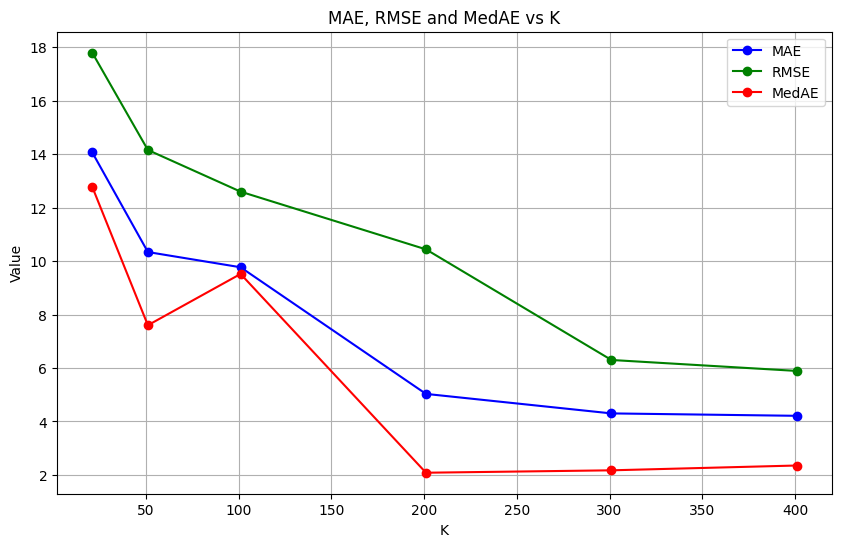

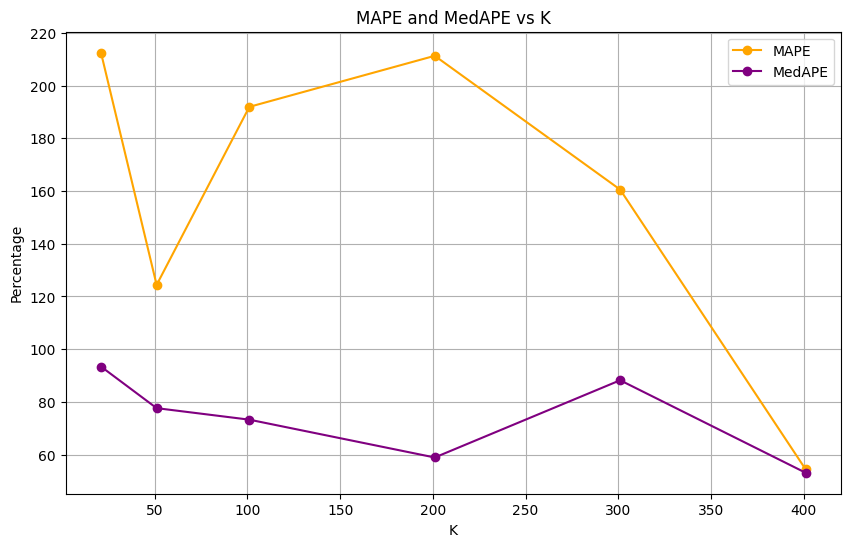

In [48]:
import matplotlib.pyplot as plt

K_values = [401, 301, 201, 101, 51, 21]
MAE = [4.21, 4.30, 5.03, 9.77, 10.34, 14.07]
RMSE = [5.89, 6.30, 10.44, 12.60, 14.16, 17.80]
MedAE = [2.35, 2.17, 2.08, 9.52, 7.60, 12.78]
MAPE = [54.46, 160.55, 211.31, 191.94, 124.38, 212.48]
MedAPE = [53.13, 88.21, 58.91, 73.26, 77.63, 93.40]

plt.figure(figsize=(10, 6))
plt.plot(K_values, MAE, marker='o', label='MAE', color='b')
plt.plot(K_values, RMSE, marker='o', label='RMSE', color='g')
plt.plot(K_values, MedAE, marker='o', label='MedAE', color='r')

plt.xlabel('K')
plt.ylabel('Value')
plt.title('MAE, RMSE and MedAE vs K')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(K_values, MAPE, marker='o', label='MAPE', color='orange')
plt.plot(K_values, MedAPE, marker='o', label='MedAPE', color='purple')

plt.xlabel('K')
plt.ylabel('Percentage')
plt.title('MAPE and MedAPE vs K')
plt.legend()
plt.grid(True)
plt.show()
